In [1]:
# ============================================================================
# INSTALLATION
# ============================================================================
print("=" * 70)
print("Installing packages...")
print("=" * 70)

import sys
import subprocess

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

# Install core dependencies only
install("torch")
install("torchvision")
install("opencv-python")
install("matplotlib")
install("pillow")
install("numpy")
install("git+https://github.com/facebookresearch/segment-anything-2.git")

print("✓ Packages installed!\n")

# ============================================================================
# DOWNLOAD SAM2 MODEL
# ============================================================================
print("Downloading SAM2 model...")

import os
import urllib.request

os.makedirs("checkpoints", exist_ok=True)

sam2_path = "checkpoints/sam2_hiera_large.pt"

if not os.path.exists(sam2_path):
    sam2_url = "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt"
    print("Downloading (879MB, one-time only)...")
    urllib.request.urlretrieve(sam2_url, sam2_path)
    print("✓ Downloaded!")
else:
    print("✓ Model already exists")

print("\n" + "=" * 70)
print("Setup complete!")
print("=" * 70 + "\n")

# ============================================================================
# IMPORTS
# ============================================================================
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# ============================================================================
# LOAD SAM2
# ============================================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}\n")

print("Loading SAM2 model...")
sam2_model = build_sam2("sam2_hiera_l.yaml", sam2_path, device=device)
predictor = SAM2ImagePredictor(sam2_model)
print("✓ SAM2 loaded successfully!\n")


Installing packages...
✓ Packages installed!

✓ Downloaded!

Setup complete!

Using device: cpu

Loading SAM2 model...
✓ SAM2 loaded successfully!



In [2]:
# ============================================================================
# TEXT-TO-PROMPT CONVERTER (Simplified)
# ============================================================================

def text_to_prompt(image, text_prompt):
    """
    Convert text to segmentation prompts
    Uses intelligent heuristics since we don't have GroundingDINO

    Returns: points, labels, box (for different segmentation methods)
    """
    h, w = image.shape[:2]

    # 1. Center point (good for centered objects)
    center_point = np.array([[w//2, h//2]])

    # 2. Grid points (good for distributed objects)
    grid_points = np.array([
        [w//2, h//2],           # center
        [w//3, h//3],           # top-left region
        [2*w//3, h//3],         # top-right region
        [w//3, 2*h//3],         # bottom-left region
        [2*w//3, 2*h//3],       # bottom-right region
    ])

    # 3. Center box (good for larger objects)
    box_size = 0.6  # 60% of image
    x1 = int(w * (1 - box_size) / 2)
    y1 = int(h * (1 - box_size) / 2)
    x2 = int(w * (1 + box_size) / 2)
    y2 = int(h * (1 + box_size) / 2)
    center_box = np.array([x1, y1, x2, y2])

    # Return all prompt types
    return {
        'center_point': (center_point, np.array([1])),
        'grid_points': (grid_points, np.ones(len(grid_points))),
        'center_box': center_box
    }

# ============================================================================
# SEGMENTATION FUNCTIONS
# ============================================================================

def segment_with_points(image, points, labels):
    """Segment using point prompts"""
    predictor.set_image(image)
    masks, scores, _ = predictor.predict(
        point_coords=points,
        point_labels=labels,
        multimask_output=True
    )
    best_idx = np.argmax(scores)
    return masks[best_idx], scores[best_idx]


def segment_with_box(image, box):
    """Segment using box prompt"""
    predictor.set_image(image)
    masks, scores, _ = predictor.predict(
        box=box[None, :],
        multimask_output=False
    )
    return masks[0], scores[0]


def auto_segment(image, text_prompt):
    """
    Automatically choose best segmentation method
    Tries multiple approaches and returns the best result
    """
    prompts = text_to_prompt(image, text_prompt)

    results = []

    # Try center point
    try:
        points, labels = prompts['center_point']
        mask, score = segment_with_points(image, points, labels)
        results.append(('Center Point', mask, score))
    except:
        pass

    # Try center box
    try:
        box = prompts['center_box']
        mask, score = segment_with_box(image, box)
        results.append(('Center Box', mask, score))
    except:
        pass

    # Try grid points
    try:
        points, labels = prompts['grid_points']
        mask, score = segment_with_points(image, points, labels)
        results.append(('Grid Points', mask, score))
    except:
        pass

    # Return best result
    if results:
        best = max(results, key=lambda x: x[2])
        return best
    else:
        # Fallback
        h, w = image.shape[:2]
        return ('Fallback', np.ones((h, w), dtype=bool), 0.5)

# ============================================================================
# VISUALIZATION
# ============================================================================

def visualize_result(image, mask, text_prompt, method, score):
    """Display segmentation results"""

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original
    axes[0].imshow(image)
    axes[0].set_title("Original Image", fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Mask
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Segmentation Mask", fontsize=14, fontweight='bold')
    axes[1].axis('off')

    # Overlay
    overlay = image.copy()
    mask_colored = np.zeros_like(image)
    mask_colored[mask > 0] = [0, 255, 0]  # Green
    overlay = cv2.addWeighted(overlay, 0.6, mask_colored, 0.4, 0)

    axes[2].imshow(overlay)
    axes[2].set_title("Mask Overlay", fontsize=14, fontweight='bold')
    axes[2].axis('off')

    title = f'Text Prompt: "{text_prompt}" | Method: {method} | Score: {score:.3f}'
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Statistics
    coverage = (mask.sum() / mask.size) * 100
    print(f"\n{'='*60}")
    print(f"Segmentation Statistics:")
    print(f"{'='*60}")
    print(f"Text Prompt: '{text_prompt}'")
    print(f"Method Used: {method}")
    print(f"Quality Score: {score:.3f}")
    print(f"Mask Coverage: {coverage:.2f}%")
    print(f"Image Size: {image.shape[1]}x{image.shape[0]}")
    print(f"{'='*60}\n")

# ============================================================================
# MAIN PIPELINE
# ============================================================================

def segment_image_pipeline(image_path, text_prompt):
    """
    Complete segmentation pipeline

    Args:
        image_path: path to image file
        text_prompt: text description (e.g., "cat", "person")
        show_comparison: if True, show all methods
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(f"Loaded image: {image.shape[1]}x{image.shape[0]}")

    # Auto-segment (chooses best method)
    print(f"\nSegmenting '{text_prompt}'...")
    method, mask, score = auto_segment(image, text_prompt)

    # Visualize
    visualize_result(image, mask, text_prompt, method, score)

    # Save results
    print("Saving results...")
    safe_prompt = text_prompt.replace(' ', '_').replace('/', '_')

    # Save mask
    mask_path = f"mask_{safe_prompt}.png"
    cv2.imwrite(mask_path, (mask * 255).astype(np.uint8))

    # Save overlay
    overlay = image.copy()
    mask_colored = np.zeros_like(image)
    mask_colored[mask > 0] = [0, 255, 0]
    overlay = cv2.addWeighted(overlay, 0.6, mask_colored, 0.4, 0)
    overlay_path = f"overlay_{safe_prompt}.png"
    cv2.imwrite(overlay_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    print(f"✓ Saved: {mask_path}")
    print(f"✓ Saved: {overlay_path}")

    return mask, overlay, mask_path, overlay_path


TEXT-DRIVEN IMAGE SEGMENTATION WITH SAM 2

Upload your image:


Saving cat image.jpg to cat image.jpg

✓ Uploaded: cat image.jpg

Enter what to segment (e.g., 'person', 'cat', 'car'): cat
Loaded image: 251x201

Segmenting 'cat'...


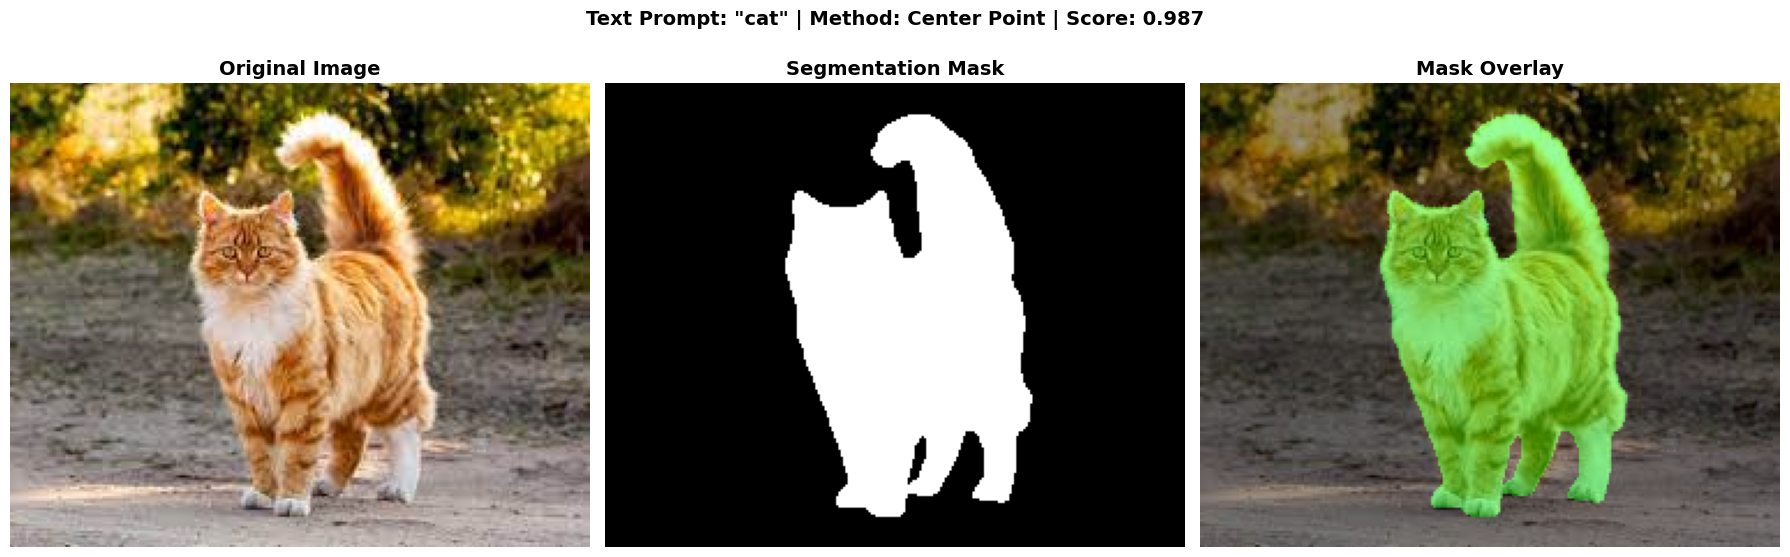


Segmentation Statistics:
Text Prompt: 'cat'
Method Used: Center Point
Quality Score: 0.987
Mask Coverage: 24.33%
Image Size: 251x201

Saving results...
✓ Saved: mask_cat.png
✓ Saved: overlay_cat.png

✓ SEGMENTATION COMPLETE!
Text prompt: 'cat'
Files saved successfully!


In [3]:

# ============================================================================
# INTERACTIVE EXECUTION
# ============================================================================

print("\n" + "="*70)
print("TEXT-DRIVEN IMAGE SEGMENTATION WITH SAM 2")
print("="*70)
print("\nUpload your image:")

from google.colab import files
uploaded = files.upload()

if uploaded:
    image_path = list(uploaded.keys())[0]
    print(f"\n✓ Uploaded: {image_path}\n")

    # Get text prompt
    print("="*70)
    text_prompt = input("Enter what to segment (e.g., 'person', 'cat', 'car'): ").strip()

    # Run segmentation
    result = segment_image_pipeline(image_path, text_prompt)

    if result:
        mask, overlay, mask_path, overlay_path = result

        print("\n" + "="*70)
        print("✓ SEGMENTATION COMPLETE!")
        print("="*70)
        print(f"Text prompt: '{text_prompt}'")
        print(f"Files saved successfully!")
        print("="*70)

else:
    print("\n⚠ No image uploaded")